# Trabalho Prático 3
## Computação Evolucionária - UFMG - 2021/1
### Alunos:
 * Jesimon Barreto
 * Daniel Piçarro

## Questão 1
Fazer com que população de strings evolua para a string objetivo: "METHINKS\*IT\*IS\*LIKE\*A\*WEASEL"

### Imports

In [1]:
import random
import string
import copy
import numpy as np
import random as rd
import matplotlib
import matplotlib.pyplot as plt

### Representação dos caracteres válidos
Afim de gerar as strings aleatórias que farão parte da população, listamos os valores ASCII dos caracteres válidos.

In [2]:
values_representation = list(np.arange(48,58)) #maiusculos
values_representation += list(np.arange(65,91))#minusculos
values_representation += [42] #*

### Geração da população
Funções relativas à geração da população.

In [3]:
# gera string aleatória somente com letras maiusculas e minusculas (sem digitos ou caracteres especiais) 
def get_random_string(length=28):
    # choose from all lowercase letter
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))

# adiciona asteriscos aleatórios em posições aleatórias da string
def add_random_asterisk(word):
    number_of_asterisks = random.randint(0,len(word))
    for asterisk in range(number_of_asterisks):
        random_idx = random.randint(0,len(word)-1)
        word_to_list = list(word)
        word_to_list[random_idx] = '*'
        word = "".join(word_to_list)
    return word

# gerar população de strings
def generate_pop(pop_size):
    pop = []
    for being in range(pop_size):
        pop.append(add_random_asterisk(get_random_string()))
    return pop

### Conversão ASCII <-> *char*
Funções para conversão de vetores e pop. de ASCII para char, e vice-versa.

In [4]:
# converter de char para int (ascii)
# recebe string, retorna vetor de inteiros
def word_to_integer_vector(word):
    return list(map(lambda x: ord(x),list(word)))

# converter pop. inteira de char para int (ascii)
def w2c_entire_pop(pop):
    return list(map(lambda x: word_to_integer_vector(x), pop))

# converter de ascii para char, retorna string
# recebe vetor de inteiros, retorna string 
def integer_to_word_vector(vector):
    return ''.join(list(map(lambda x: chr(x),vector)))

# converter pop. inteira de ascii para char
def c2w_entire_pop(pop):
    return list(map(lambda x: integer_to_word_vector(x), pop))

### Cálculo de Fitness
Função para cálculo de fitness dos indivíduos. 

In [5]:
# função de custo
# soma das diferenças entre os valores das duas strings
def fitness_nq(int_vec_word, target="METHINKS*IT*IS*LIKE*A*WEASEL"):
    int_target = word_to_integer_vector(target)
    return np.sum(np.abs(int_vec_word - int_target))

# recebe vetor de ints (que representa uma palavra)
def evaluate_loss_function(int_vec_word, target="METHINKS*IT*IS*LIKE*A*WEASEL"):
    print(f"Word:   {integer_to_word_vector(int_vec_word)}\n")
    print(f"Target: {target}\n")
    result = []
    int_target = word_to_integer_vector(target)
    for i in range(len(int_vec_word)):
        result.append(np.abs(int_vec_word[i] - int_target[i]))
    return np.sum(result)

### Mutação
Funções usadas para a mutação.

In [6]:
# retorna caracter dentro da lista dos caracteres válidos
def get_caract_random():
    p = random.randint(0,len(values_representation)-1)
    return values_representation[p]

# função de mutação escolhe uma posição dentro de um indivíduo e a 
# troca por um caractere aleatório (dentro dos caracteres válidos)
def mutation(offspring, mutation_rate):
    size_ind = len(offspring[0])
    population_copy = copy.copy(offspring)
    for i in range(len(population_copy)):
        if float(random.randint(0, 10))/10 <= mutation_rate:
            loc = random.randint(0,size_ind-1)
            mut = get_caract_random()
            population_copy[i,loc] = mut
    return population_copy

### Seleção dos melhores indivíudos (ranking dos indivíduos)

Primeiramente, foi considerado o uso da substituição da geração atual inteira pela offsprin, o que seria alcançado cruzando todos os indivíduos entre si.
No entanto, não o fizemos.

Chegou-se na conclusão que não fazia muito sentido usar essa abordagem, tendo em vista que não estava sendo forçada a seleção natural.
Foi feito como na Tarefa #1: substituiram-se os piores da geração anterior pelos melhores da nova geração.

In [7]:
def selection(population, cut, k = 5):
    scores = []
    # escolhendo k indivíduos aleatórios     
    for individual in random.choices(population, k=k):
        fitness_score = fitness_nq(individual)
        scores.append((fitness_score, individual))
    sorted_scores = sorted(scores, key=lambda tup: tup[0])
    best_ones = sorted_scores[:cut] 
    return list(map(lambda x: x[1], best_ones))

### Função de Crossover
Recebe dois indivíduos e gera dois filhos. 
Uso de um ponto de corte aleatório.
Valores pares.

In [8]:
# crossover (reprodução)
def crossover(subset_parents, cross_over_rate):
    new_ = []
    if float(rd.randint(0, 10))/10 <= cross_over_rate:
        size_n = len(subset_parents[0])
        for i in range(0,int(len(subset_parents)/2),2):
            cut_v = random.randint(1, size_n-1)
            son1 = np.concatenate((subset_parents[i][0:cut_v], subset_parents[i+1][cut_v:]))
            son2 = np.concatenate((subset_parents[i+1][0:cut_v], subset_parents[i][cut_v:]))
            new_.append(son1)
            new_.append(son2)
    else:
        new_ = subset_parents
        
    return np.array(new_)

### Função de Substituição da população - Seleção Natural

In [9]:
# Seleção natural
# sustituir os piores pelos melhores
def replacement(offspring_new, pop):
    pop = np.concatenate((pop,offspring_new), axis=0)
    evaluate_v = []
    for indv in pop:
        evaluate_v.append(fitness_nq(indv))
    
    sorted_ = sorted(range(len(evaluate_v)), key=evaluate_v.__getitem__)
    pop_order = pop[sorted_]
    
    pop_order = pop_order[:-len(offspring_new)]
    
    return pop_order

### Executando a evolução

In [10]:
cross_over_rate = 0.7
mutation_rate = 0.7
n_inter_max = 1000
cut = 40
k = 100

pop = generate_pop(200)
pop = np.array(w2c_entire_pop(pop))
pop

array([[102, 101, 116, ...,  42,  42,  42],
       [122,  87,  88, ..., 120, 101, 117],
       [107,  69, 104, ...,  90,  42, 106],
       ...,
       [102,  79,  79, ...,  76,  97, 102],
       [ 42, 108,  42, ..., 104,  42, 100],
       [ 88, 117,  70, ...,  82,  89,  89]])

In [11]:
sol = []
n_iter = 0
fitness_avg = []
best_of_generation = []
smallest_fitness = 1000

while n_iter < n_inter_max and smallest_fitness > 0:
    
    subset_parents = selection(pop, cut, k = k)
    offspring = crossover(subset_parents, cross_over_rate)
    offspring_new = mutation(offspring, mutation_rate)
    pop = replacement(offspring_new, pop)
    fitness_scores = []
    last = fitness_nq(pop[0])
    
    for p in pop:
        v = fitness_nq(p)
        fitness_scores.append(v)
        if last < smallest_fitness:
            smallest_fitness = last
            sol = copy.copy(pop[0])
    

    best_of_generation.append(smallest_fitness)
            
    current_fitness_avg = sum(fitness_scores)/len(fitness_scores)
    fitness_avg.append(current_fitness_avg)
    
    if n_iter%80 == 0:
        print (f"Fitness da geração menor valor {n_iter}: {last}\n")    
    n_iter += 1

print (f"Fitness da geração menor valor {n_iter}: {last}\n")    
print(f"Melhor solução encontrada: {sol}")
print(f"Fitness da melhor solução encontrada: {smallest_fitness}")

Fitness da geração menor valor 0: 509

Fitness da geração menor valor 80: 59

Fitness da geração menor valor 160: 24

Fitness da geração menor valor 240: 11

Fitness da geração menor valor 320: 5

Fitness da geração menor valor 400: 2

Fitness da geração menor valor 480: 1

Fitness da geração menor valor 560: 1

Fitness da geração menor valor 568: 0

Melhor solução encontrada: [77 69 84 72 73 78 75 83 42 73 84 42 73 83 42 76 73 75 69 42 65 42 87 69
 65 83 69 76]
Fitness da melhor solução encontrada: 0


### Solução encontrada
Como pode ser visto, após 568 iterações, obteu-se um indivíduo igual ao objetivo.

In [12]:
print('Número de interações: {}'.format(n_iter))
print(f"Result: {integer_to_word_vector(sol)}")

Número de interações: 568
Result: METHINKS*IT*IS*LIKE*A*WEASEL


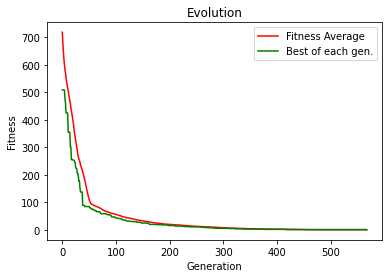

In [13]:
# Plotting both the curves simultaneously
X = range(n_iter)
plt.plot(X, fitness_avg, color='r', label='Fitness Average')
plt.plot(X, best_of_generation, color='g', label='Best of each gen.')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Evolution")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()